#  Accelerating DDPM with DIP-based Initial Priors

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision import datasets as dtsets
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import os
import random
import time
import matplotlib.pyplot as plt
import math

## Set Random Seed

In [2]:
def set_seed(seed=2400, loader=None):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    try:
        loader.sampler.generator.manual_seed(seed)
    except AttributeError:
        pass

In [3]:
set_seed(seed=2400, loader=None)

## Load Data

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
IMG_SIZE = 64

In [5]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

def save_tensor_image(tensor, filename):
    tensor = tensor.clone().detach().squeeze(0)
    image = transforms.ToPILImage()(tensor)
    image.save(filename)

In [7]:
def show_tensor_image(image):
    '''
    Plots image after applying reverse transformations.
    '''
    image = image.detach().cpu()
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

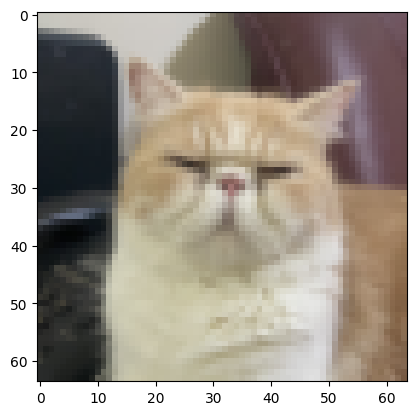

In [8]:
data = load_image("./data/mycat.jpg")
show_tensor_image(data)

In [9]:
from skimage.metrics import structural_similarity as ssim

def get_ssim(img1, img2):
    img1 = img1.detach().to('cpu').numpy()
    img2 = img2.detach().to('cpu').numpy()

    img1 = np.transpose(img1.squeeze(), (1, 2, 0))
    img2 = np.transpose(img2.squeeze(), (1, 2, 0))
    
    # calculate SSIM for each channel
    ssim_score, _ = ssim(img1, img2, win_size=3, multichannel=True, full=True, data_range=1.0)
    return ssim_score

## DIP training

In [10]:
# U-Net
class DIP_Model(nn.Module):
    def __init__(self):
        super(DIP_Model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
def train_dip(target_image, num_iterations=1000, save_every=100, print_info=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    DIP_model = DIP_Model().to(device)
    optimizer = optim.Adam(DIP_model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    target_image = target_image.to(device)
    
    # random noise
    input_noise = torch.randn_like(target_image).to(device)

    start = time.time()
    total_time = 0

    loss_history = []
    imgs = []

    for i in range(num_iterations):

        optimizer.zero_grad()
        output = DIP_model(input_noise)
        loss = criterion(output, target_image)
        loss.backward()
        optimizer.step()

        if i % save_every == 0:
            end = time.time()
            total_time = total_time + (end-start)
            if print_info:
                print(f'Iteration {i:-4d}: Loss={loss.item():-.6f}, Spent time={end-start:-.4f}(s)')
            start = time.time()
            loss_history.append(loss.item())
            imgs.append(output)
            
    if print_info:
            print(f'Iteration {num_iterations:-4d}: Loss={loss.item():-.6f}, Spent time={end-start:-.4f}(s)')
            print(f'Total Spent time={total_time:-.4f}(s)')
    loss_history.append(loss.item())
    imgs.append(output)
    
    return loss_history, imgs, total_time

In [12]:
num_iterations = 2000
save_every = 100
loss_history, result, total_time = train_dip(data, num_iterations, save_every, print_info=True)

Iteration    0: Loss=0.453538, Spent time=1.1456(s)
Iteration  100: Loss=0.218675, Spent time=0.3711(s)
Iteration  200: Loss=0.218495, Spent time=0.4024(s)
Iteration  300: Loss=0.216455, Spent time=0.4296(s)
Iteration  400: Loss=0.124599, Spent time=0.4377(s)
Iteration  500: Loss=0.113435, Spent time=0.4423(s)
Iteration  600: Loss=0.111856, Spent time=0.4446(s)
Iteration  700: Loss=0.111457, Spent time=0.4363(s)
Iteration  800: Loss=0.111214, Spent time=0.4403(s)
Iteration  900: Loss=0.111085, Spent time=0.4369(s)
Iteration 1000: Loss=0.111004, Spent time=0.4342(s)
Iteration 1100: Loss=0.110958, Spent time=0.4362(s)
Iteration 1200: Loss=0.110906, Spent time=0.4335(s)
Iteration 1300: Loss=0.110875, Spent time=0.4337(s)
Iteration 1400: Loss=0.110849, Spent time=0.4377(s)
Iteration 1500: Loss=0.110832, Spent time=0.4369(s)
Iteration 1600: Loss=0.110819, Spent time=0.4459(s)
Iteration 1700: Loss=0.110816, Spent time=0.4364(s)
Iteration 1800: Loss=0.110799, Spent time=0.4310(s)
Iteration 19

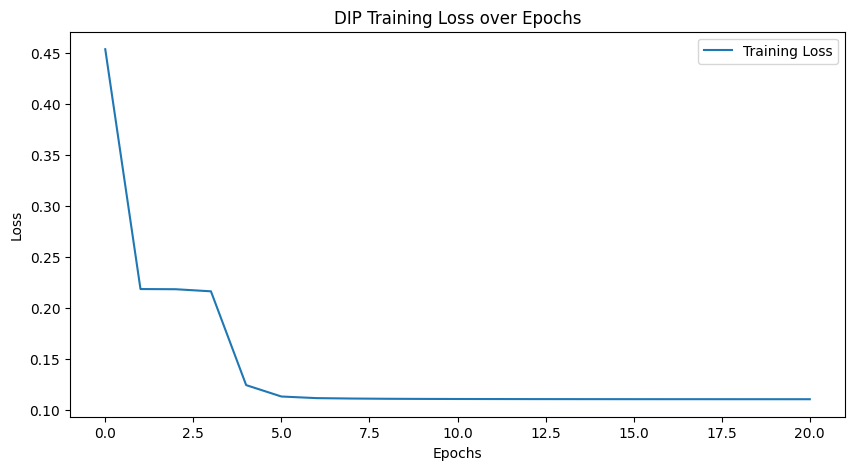

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("DIP Training Loss over Epochs")
plt.legend()
plt.show()

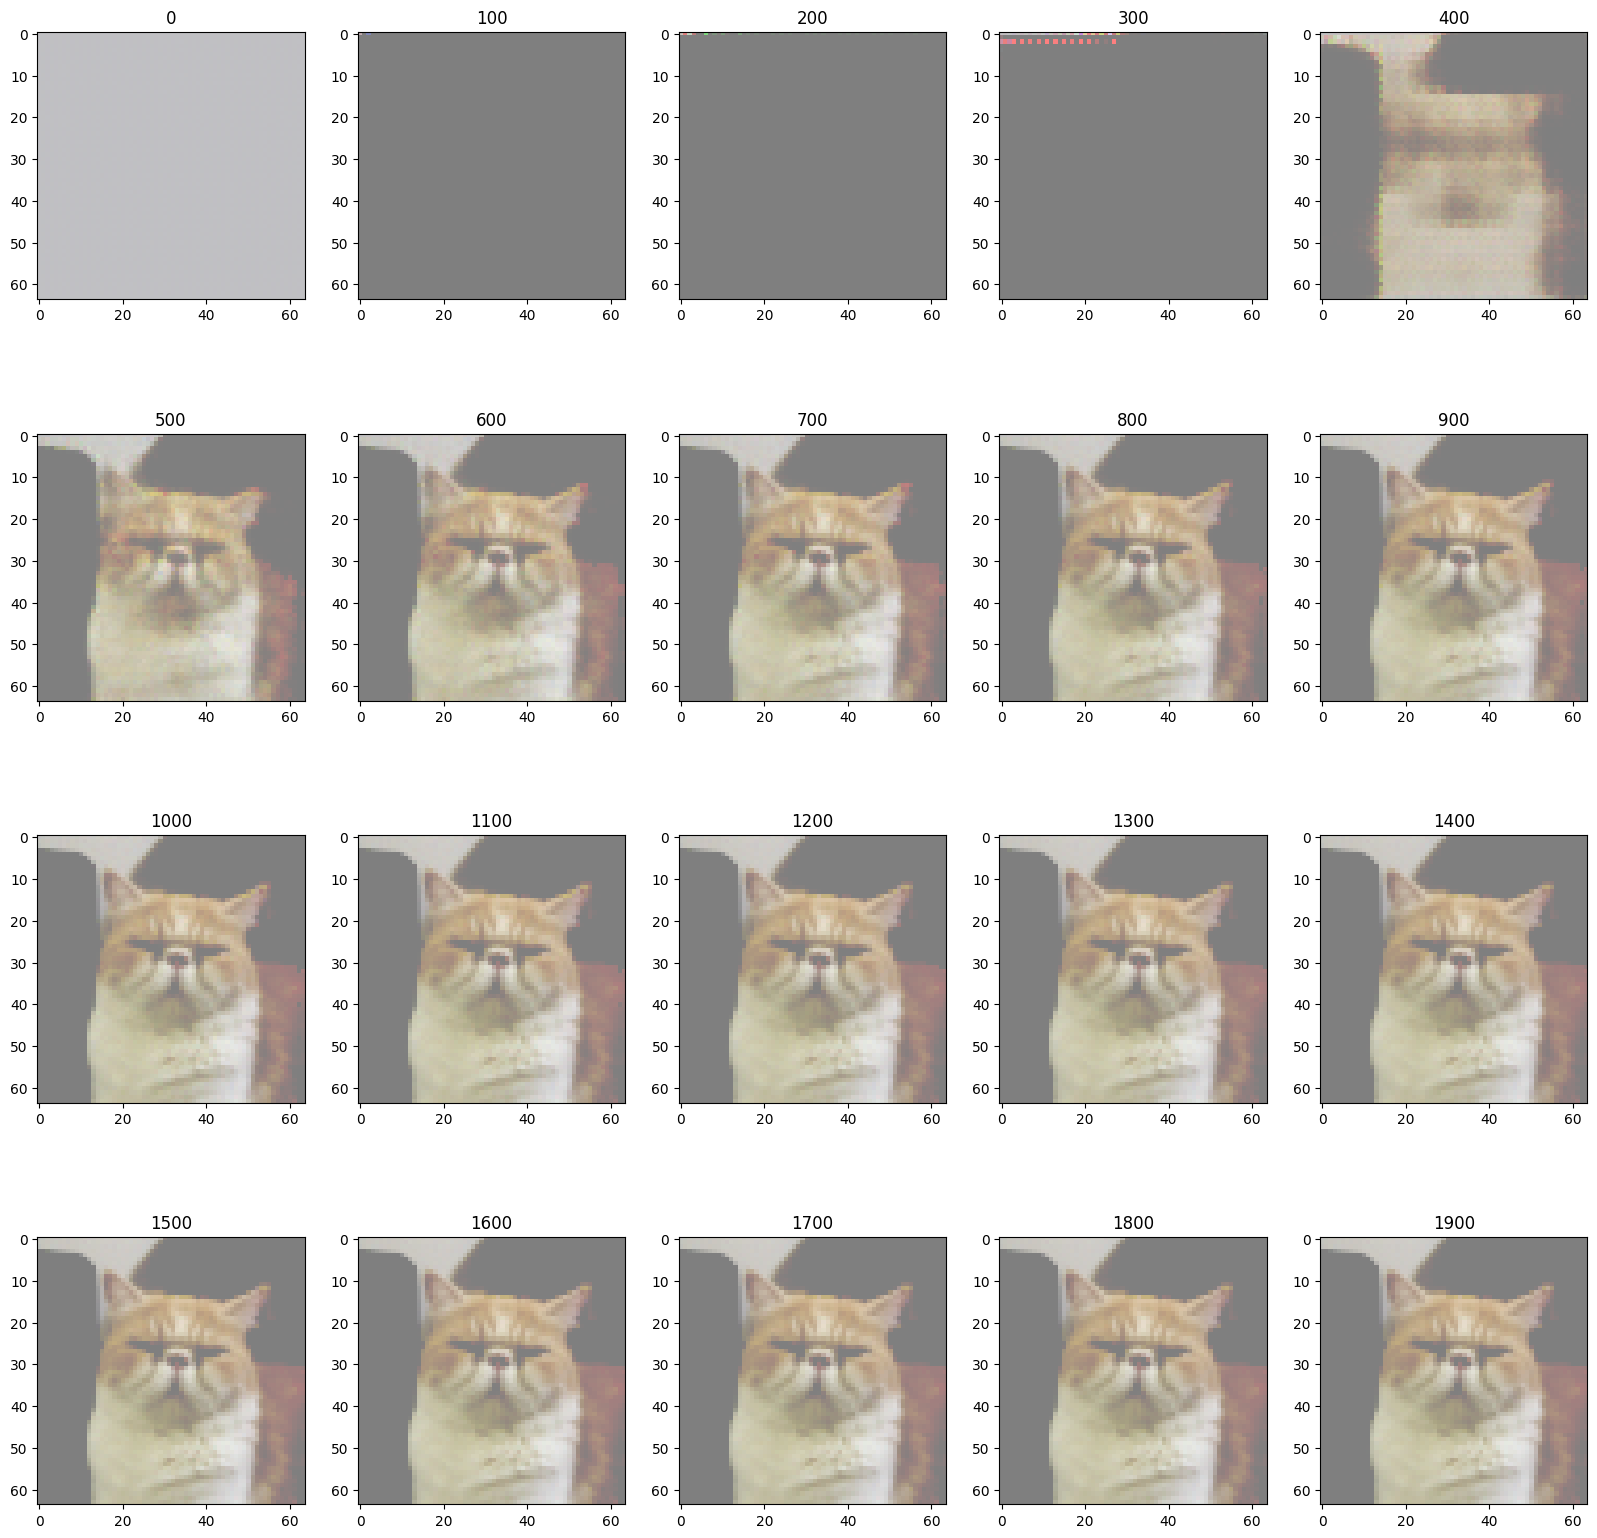

In [14]:
total = int(num_iterations / save_every)
plt.figure(figsize=(20,20))
for i in range(total):
    plt.subplot(4, 5, i+1)
    plt.title(f'{i * save_every}')
    show_tensor_image(result[i].detach().cpu())

## DDPM

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        h = self.bn1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        
        h = self.bn2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeds = math.log(10000) / (half_dim - 1)
        embeds = torch.exp(torch.arange(half_dim, device=device) * -embeds)
        embeds = time[:, None] * embeds[None, :]
        embeds = torch.cat((embeds.sin(), embeds.cos()), dim=-1)
        return embeds


class DDPM_Model(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                PositionalEncoding(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([ConvBlock(down_channels[i], down_channels[i+1], 
                                    time_emb_dim) for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([ConvBlock(up_channels[i], up_channels[i+1],
                                        time_emb_dim, up=True) for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        
        # Embedd time
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [16]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

In [17]:
# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = torch.nn.functional.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [18]:
def get_index_from_list(vals, t, x_shape):

    """
    Returns values from vals for corresponding timesteps
    while considering the batch dimension.

    """
    batch_size = t.shape[0]
    output = vals.gather(-1, t.cpu())
    return output.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [19]:
def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it after adding noise t times.
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)

    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

In [20]:
def get_loss(model, x_0, t, betas):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy.to(device), t)
    return nn.MSELoss()(noise_pred, noise)

In [21]:
def sample_timestep(model, x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean, model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean, model_mean + torch.sqrt(posterior_variance_t) * noise

In [27]:
def sample_plot_image(model, input_data, DIP_epoch, T_sample):
    img_size = IMG_SIZE
    
    # img = torch.randn((1, 3, img_size, img_size), device=device)
    loss_history, result, DIP_time = train_dip(data, num_iterations, save_every, print_info=False)
    img = result[-1]
    img_noisy = result[-1]

    if print_image:
        plt.figure(figsize=(20,2))
        plt.axis('off')
    num_images = 10
    stepsize = int(T_sample/num_images)
    DDPM_time = 0
    
    for i in range(0,T_sample)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        start = time.time()
        img, img_noisy = sample_timestep(model, img_noisy, t)
        end = time.time()
        DDPM_time = DDPM_time + (end-start)
        if i % stepsize == 0 and print_image:
            plt.subplot(1, num_images, int(i/stepsize+1))
            show_tensor_image(img.detach().cpu())
    if print_image:
        plt.show()
    score = get_ssim(img, data)
    print(f"DIP   generation time = {DIP_time:.6f}")
    print(f"DDPM  generation time = {DDPM_time:.6f}")
    print(f"total generation time = {DIP_time+DDPM_time:.6f}")
    print(f"SSIM score: {score:.4f}")
    print("---------------------------------------------------------")

    return score, DIP_time+DDPM_time

In [23]:
def train_ddpm(input_data, num_epochs=100, save_every=10, T=300, DIP_epoch=1000, T_sample=50):
    model = DDPM_Model().to(device)
    model.train()
    
    loss_history = []
    ssim_history = []
    time_history = []
    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    betas = linear_beta_schedule(timesteps=T)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        t = torch.randint(0, len(betas), (1,), device=device).long()
        loss = get_loss(model, input_data, t, betas)
        loss.backward()
        optimizer.step()

        loss_history.append(loss)
        
        if epoch % save_every == 0:
            print(f"Epoch {epoch:<3d}: Loss: {loss:.4f}")
            ssim_score, gener_time = sample_plot_image(model, input_data, DIP_epoch, T_sample)
            ssim_history.append(ssim_score)
            time_history.append(gener_time)

    return loss_history, ssim_history, time_history

In [24]:
print_image = False

In [28]:
DDPM_loss_history, DDPM_ssim_history, DDPM_time_history = train_ddpm(data, num_epochs=1001, save_every=10, T=300, DIP_epoch=500, T_sample=100)

Epoch 0  : Loss: 1.0201
DIP   generation time = 6.334005
DDPM  generation time = 1.220585
total generation time = 7.554590
SSIM score: 0.0507
---------------------------------------------------------
Epoch 10 : Loss: 0.9139
DIP   generation time = 6.426509
DDPM  generation time = 1.214861
total generation time = 7.641370
SSIM score: 0.0555
---------------------------------------------------------
Epoch 20 : Loss: 0.8368
DIP   generation time = 6.327645
DDPM  generation time = 1.208699
total generation time = 7.536344
SSIM score: 0.0626
---------------------------------------------------------
Epoch 30 : Loss: 0.7837
DIP   generation time = 6.926388
DDPM  generation time = 1.213565
total generation time = 8.139953
SSIM score: 0.0593
---------------------------------------------------------
Epoch 40 : Loss: 0.6942
DIP   generation time = 5.772115
DDPM  generation time = 1.155207
total generation time = 6.927323
SSIM score: 0.0760
---------------------------------------------------------


In [29]:
DDPM_loss_history_50, DDPM_ssim_history_50, DDPM_time_history_50 = train_ddpm(data, num_epochs=1001, save_every=10, T=300, DIP_epoch=500, T_sample=50)

Epoch 0  : Loss: 1.0552
DIP   generation time = 4.535731
DDPM  generation time = 0.577283
total generation time = 5.113014
SSIM score: 0.1810
---------------------------------------------------------
Epoch 10 : Loss: 0.9113
DIP   generation time = 4.550215
DDPM  generation time = 0.576978
total generation time = 5.127193
SSIM score: 0.1899
---------------------------------------------------------
Epoch 20 : Loss: 0.8686
DIP   generation time = 4.559806
DDPM  generation time = 0.576903
total generation time = 5.136709
SSIM score: 0.1951
---------------------------------------------------------
Epoch 30 : Loss: 0.7466
DIP   generation time = 4.564600
DDPM  generation time = 0.576833
total generation time = 5.141433
SSIM score: 0.2118
---------------------------------------------------------
Epoch 40 : Loss: 0.6772
DIP   generation time = 4.543943
DDPM  generation time = 0.576654
total generation time = 5.120597
SSIM score: 0.2272
---------------------------------------------------------


In [30]:
DDPM_loss_history_30, DDPM_ssim_history_30, DDPM_time_history_30 = train_ddpm(data, num_epochs=1001, save_every=10, T=300, DIP_epoch=500, T_sample=30)

Epoch 0  : Loss: 1.0576
DIP   generation time = 5.760718
DDPM  generation time = 0.347013
total generation time = 6.107731
SSIM score: 0.2946
---------------------------------------------------------
Epoch 10 : Loss: 0.9427
DIP   generation time = 5.905698
DDPM  generation time = 0.374168
total generation time = 6.279866
SSIM score: 0.3018
---------------------------------------------------------
Epoch 20 : Loss: 0.8802
DIP   generation time = 7.831034
DDPM  generation time = 0.378130
total generation time = 8.209164
SSIM score: 0.2933
---------------------------------------------------------
Epoch 30 : Loss: 0.8099
DIP   generation time = 8.388572
DDPM  generation time = 0.374698
total generation time = 8.763270
SSIM score: 0.3094
---------------------------------------------------------
Epoch 40 : Loss: 0.7223
DIP   generation time = 8.374806
DDPM  generation time = 0.394495
total generation time = 8.769301
SSIM score: 0.3264
---------------------------------------------------------


In [31]:
DDPM_loss_history_DIP, DDPM_ssim_history_DIP, DDPM_time_history_DIP = train_ddpm(data, num_epochs=1001, save_every=10, T=300, DIP_epoch=800, T_sample=30)

Epoch 0  : Loss: 1.0432
DIP   generation time = 6.331439
DDPM  generation time = 0.364469
total generation time = 6.695908
SSIM score: 0.2982
---------------------------------------------------------
Epoch 10 : Loss: 0.9385
DIP   generation time = 6.883881
DDPM  generation time = 0.378302
total generation time = 7.262182
SSIM score: 0.3139
---------------------------------------------------------
Epoch 20 : Loss: 0.8532
DIP   generation time = 7.702102
DDPM  generation time = 0.375236
total generation time = 8.077338
SSIM score: 0.3221
---------------------------------------------------------
Epoch 30 : Loss: 0.7807
DIP   generation time = 7.665013
DDPM  generation time = 0.375335
total generation time = 8.040348
SSIM score: 0.0024
---------------------------------------------------------
Epoch 40 : Loss: 0.6786
DIP   generation time = 7.607627
DDPM  generation time = 0.374823
total generation time = 7.982450
SSIM score: 0.3367
---------------------------------------------------------


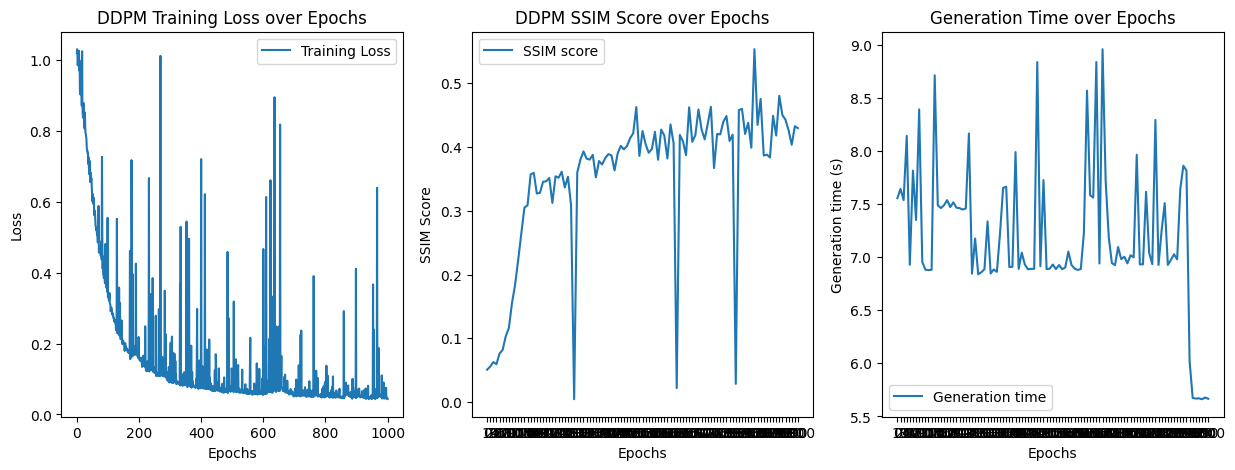

In [49]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.plot(torch.tensor(DDPM_loss_history, device="cpu"), label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("DDPM Training Loss over Epochs")
plt.legend()

plt.subplot(1,3,2)
plt.plot(torch.tensor(DDPM_ssim_history, device="cpu"), label="SSIM score")
plt.xlabel("Epochs")
plt.ylabel("SSIM Score")
plt.title("DDPM SSIM Score over Epochs")
plt.xticks(ticks=range(0,len(DDPM_ssim_history)), labels=range(0,len(DDPM_ssim_history)*10, 10))
plt.legend()

plt.subplot(1,3,3)
plt.plot(torch.tensor(DDPM_time_history, device="cpu"), label="Generation time")
plt.xlabel("Epochs")
plt.ylabel("Generation time (s)")
plt.title("Generation Time over Epochs")
plt.xticks(ticks=range(0,len(DDPM_ssim_history)), labels=range(0,len(DDPM_ssim_history)*10, 10))
plt.legend()


plt.show()

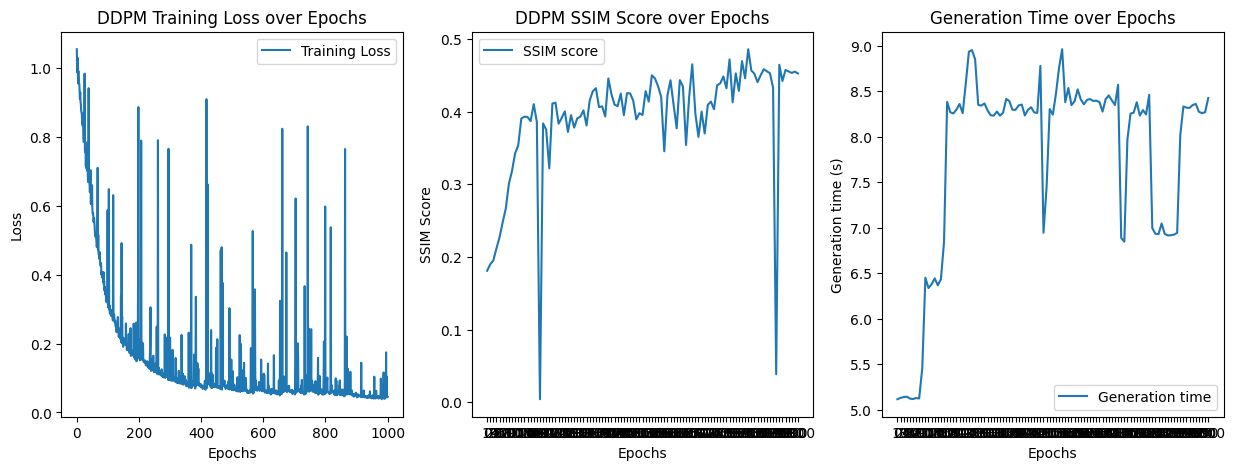

In [50]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.plot(torch.tensor(DDPM_loss_history_50, device="cpu"), label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("DDPM Training Loss over Epochs")
plt.legend()

plt.subplot(1,3,2)
plt.plot(torch.tensor(DDPM_ssim_history_50, device="cpu"), label="SSIM score")
plt.xlabel("Epochs")
plt.ylabel("SSIM Score")
plt.title("DDPM SSIM Score over Epochs")
plt.xticks(ticks=range(0,len(DDPM_ssim_history)), labels=range(0,len(DDPM_ssim_history)*10, 10))
plt.legend()

plt.subplot(1,3,3)
plt.plot(torch.tensor(DDPM_time_history_50, device="cpu"), label="Generation time")
plt.xlabel("Epochs")
plt.ylabel("Generation time (s)")
plt.title("Generation Time over Epochs")
plt.xticks(ticks=range(0,len(DDPM_ssim_history)), labels=range(0,len(DDPM_ssim_history)*10, 10))
plt.legend()


plt.show()

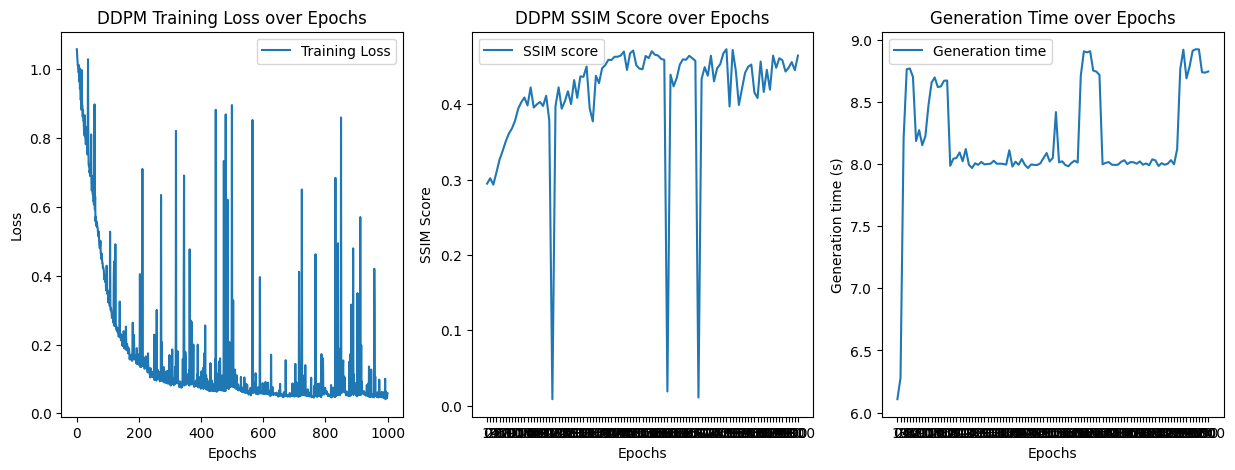

In [51]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.plot(torch.tensor(DDPM_loss_history_30, device="cpu"), label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("DDPM Training Loss over Epochs")
plt.legend()

plt.subplot(1,3,2)
plt.plot(torch.tensor(DDPM_ssim_history_30, device="cpu"), label="SSIM score")
plt.xlabel("Epochs")
plt.ylabel("SSIM Score")
plt.title("DDPM SSIM Score over Epochs")
plt.xticks(ticks=range(0,len(DDPM_ssim_history)), labels=range(0,len(DDPM_ssim_history)*10, 10))
plt.legend()

plt.subplot(1,3,3)
plt.plot(torch.tensor(DDPM_time_history_30, device="cpu"), label="Generation time")
plt.xlabel("Epochs")
plt.ylabel("Generation time (s)")
plt.title("Generation Time over Epochs")
plt.xticks(ticks=range(0,len(DDPM_ssim_history)), labels=range(0,len(DDPM_ssim_history)*10, 10))
plt.legend()


plt.show()

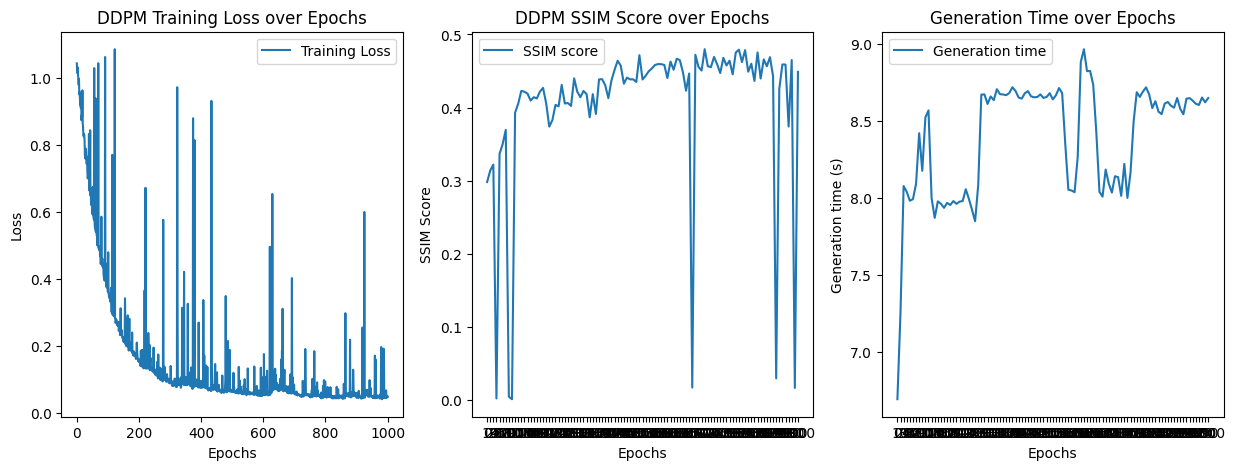

In [52]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.plot(torch.tensor(DDPM_loss_history_DIP, device="cpu"), label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("DDPM Training Loss over Epochs")
plt.legend()

plt.subplot(1,3,2)
plt.plot(torch.tensor(DDPM_ssim_history_DIP, device="cpu"), label="SSIM score")
plt.xlabel("Epochs")
plt.ylabel("SSIM Score")
plt.title("DDPM SSIM Score over Epochs")
plt.xticks(ticks=range(0,len(DDPM_ssim_history)), labels=range(0,len(DDPM_ssim_history)*10, 10))
plt.legend()

plt.subplot(1,3,3)
plt.plot(torch.tensor(DDPM_time_history_DIP, device="cpu"), label="Generation time")
plt.xlabel("Epochs")
plt.ylabel("Generation time (s)")
plt.title("Generation Time over Epochs")
plt.xticks(ticks=range(0,len(DDPM_ssim_history)), labels=range(0,len(DDPM_ssim_history)*10, 10))
plt.legend()


plt.show()